# Simulacion de voronoi python

In [17]:
import pandas as pd
import numpy as np
import csv
import urllib2
import urllib
import time
import json 
import requests
import pickle
import os.path
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline


########################### Flags ##############################
UPDATE_DATA = False

######################## Constants #############################
DELAY = 7

MINIMUM_RANK = 3
FILE_NAME = 'connect_%s_towns.txt'
NETWORK_TYPE = 'type3G'
RELIABILITY = 'reliability'
FIRST_ITEM = 0
BIG_POPULATION = 10000
MEDIUM_POPULATION = 1000
SMALL_POPULATION = 100
MIN_NETWORK_PARM = 11

In [29]:
#####################################################################
#           Function to obtain connectivity by village              #
# @param lat (double) latitude village                              #
# @param lon (double) longitude village                             #
# @param dist (int)                                                 #
# @param net (int) network type G3                                  #
#####################################################################
def get_connect (lat, lon, dist=20, net=3):
    url = "http://api.opensignal.com/v2/networkstats.json"
    apikey = "apikey=f6feae3aa4ddf7d4d25522cf3256d39d"
    network_type = "network_type="+str(net)
    json_format = "json_format=2" 
    distance = "distance="+ str(dist)                    
    network_inf = []
    
    for lat_i, lon_i in zip(lat,lon):
        lat = "lat=" + str(lat_i)
        lng = "lng=" + str(lon_i)
        url_values = "&"+lat+"&"+lng+"&"+distance+"&"+json_format+"&"+network_type+"&"+apikey
        full_url = url + '?' + url_values
        r = requests.get(full_url)
        network_inf.append(json.loads(r.text))
        time.sleep(DELAY)

    return network_inf


In [30]:
#####################################################################
#           Function to obtain connectivity by class                #
# @param class_town (dataframe) contain all values from cv          #
# @param classname (string) name of files to store                  #
#####################################################################
def obtain_town_data(class_town, classname, update_data = False):
    file_name = FILE_NAME % classname
    if update_data or not os.path.isfile(file_name):
        #Only update if is necesary 
        connect_class_towns = get_connect(class_town['lat'].values, class_town['lon'].values)
        with open(file_name, 'wb') as f:
            pickle.dump(connect_class_towns, f)
    else:
        #Else read from file
        with open(file_name, 'rb') as f:
            connect_class_towns = pickle.load(f)
    return connect_class_towns

In [31]:
#Read data from censo cvs
labels = ["idx","ent","mun","nom_mun","nom_loc","lon","lat","pob"]
data = pd.read_csv('dataCenso.csv', names=labels, low_memory = False)

#Remove idx column
del data['idx']


In [32]:
data.head()

,ent,mun,nom_mun,nom_loc,lon,lat,pob
0,ent,mun,nom_mun,nom_loc,long,lat,pob
1,1,1,Aguascalientes,Aguascalientes,-102.411111111111,22.0083333333333,722250
2,1,1,Aguascalientes,Granja Adelita,-102.436111111111,21.9194444444444,14
3,1,1,Aguascalientes,Agua Azul,-102.425,21.8916666666667,37
4,1,1,Aguascalientes,Rancho Alegre,-102.427777777778,21.8944444444444,10


In [49]:
# We ll work with entity 7 (Chiapas)
entity_data = data[data['ent']=='7']
population = pd.to_numeric(entity_data['pob'])

# Divide by population in three classes, big, medium and small
big_towns = entity_data[population > MEDIUM_POPULATION]
medium_towns = entity_data[(population > MEDIUM_POPULATION) & (population < BIG_POPULATION)]
small_towns = entity_data[(population > SMALL_POPULATION) & (population < MEDIUM_POPULATION)]
union_towns = pd.concat([big_towns, medium_towns])


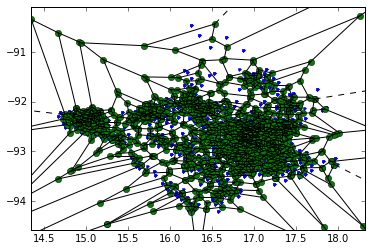

In [53]:
#####################################################################
#                       UNION TOWNS                                 # 
#####################################################################
connect_union_towns = obtain_town_data(big_towns, 'big_medium', UPDATE_DATA)
#We ll work with networkRank
rank_union = [item['networkRank'] for item in connect_union_towns if 'networkRank' in item.keys()]

#   Filter by min_ranl, networkRank is a list at least one element, only work with first element
rank_union = [item[FIRST_ITEM] for item in rank_union if len(item[FIRST_ITEM]) >= MINIMUM_RANK] 

net_type_union = [item[NETWORK_TYPE] for item in rank_union]

#   Filter by min network param 
net_type_union = [item for item in net_type_union if len(item)  >= MIN_NETWORK_PARM]

# Reliability of each station
relia_union = [item[RELIABILITY] for item in net_type_union]

#Voronoi with library                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
vor = Voronoi(zip(union_towns['lat'].values, union_towns['lon'].values))
voronoi_plot_2d(vor)
plt.show()

In [60]:
len(big_towns)

612